In [1]:
import numpy as np
import pandas as pd
import os
from lib import data_processing as dp
from sklearn.preprocessing import StandardScaler,normalize,MinMaxScaler
import time
import h5py
# import pywt
from scipy.fft import fft
from scipy import signal
from scipy.stats import zscore
# from scipy.integrate import cumtrapz
# from scipy import ndimage
from itertools import permutations,combinations
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from lib import utils
import pywt

In [26]:
# read file name of data with various Labels
df = pd.read_csv('./useful_data_label.csv',index_col=0) 
# read file name of data with only label 0
df2 = pd.read_csv('./unuseful_data_label.csv',index_col=0)
# read some of the da|ta with only label 0
df3 = pd.read_csv('./data/file_name.txt',header=None)

In [27]:
ind = df2.iloc[1].isna()
files = np.concatenate([np.array(df.columns),np.array('normal/'+df2.columns[ind])])

# Signal segmentation

In [29]:
temp = pd.read_csv('./data/'+files[15])

Text(0.5, 0, 'time $[ms]$')

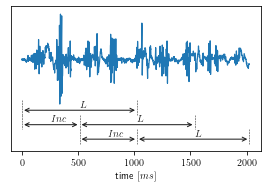

In [32]:
L = 2024
arh = -350
t=np.arange(0,L)
yt = np.arange(-600,400,200)
xt = np.arange(0,2001,500)

lw = 0.5
font = 'Serif'
ls = '--'
col = 'k'
ms = 10
height = -390

# sns.set_style(style='white')

plt.figure(figsize=(0.7*6.4,0.7*3.8))
plt.rcParams.update({"text.usetex": True})
plt.plot(t,temp.iloc[6000:6000+L,4],linewidth=1.2)
# plt.annotate(s='', xy=(1024,arh), xytext=(0,arh), arrowprops=dict(arrowstyle='<->'))

p = patches.FancyArrowPatch((0, height), (1024, height), arrowstyle='<->', mutation_scale=ms, color=col)
plt.gca().add_patch(p)
plt.plot([1024,1024],[height+75,height-35],color=col,linestyle=ls, linewidth=lw)
plt.plot([0,0],[height+75,height-35],color=col,linestyle=ls,linewidth=lw)
plt.text(512,height+25,'$L$',family=font,color=col,size='medium',style='italic')

p = patches.FancyArrowPatch((512, height-110), (1536, height-110), arrowstyle='<->', mutation_scale=ms, color=col)
plt.gca().add_patch(p)
plt.plot([1536,1536],[height-35,height-145],color=col,linestyle=ls,linewidth=lw)
plt.plot([512,512],[height-35,height-145],color=col,linestyle=ls,linewidth=lw)
plt.text(1024,height-85,'$L$',family=font,color=col,size='medium',style='italic')

p = patches.FancyArrowPatch((0, height-110), (512, height-110), arrowstyle='<->', mutation_scale=ms, color=col)
plt.gca().add_patch(p)
plt.plot([0,0],[height-35,height-145],color=col,linestyle=ls,linewidth=lw)
plt.text(256,height-85,'$Inc$',family=font,color=col,size='medium',style='italic')

p = patches.FancyArrowPatch((1024, height-220), (2024, height-220), arrowstyle='<->', mutation_scale=ms, color=col)
plt.gca().add_patch(p)
plt.plot([2024,2024],[height-145,height-255],color=col,linestyle=ls,linewidth=lw)
plt.plot([1024,1024],[height-145,height-255],color=col,linestyle=ls,linewidth=lw)
plt.text(1536,height-195,'$L$',family=font,color=col,size='medium')

p = patches.FancyArrowPatch((512, height-220), (1024, height-220), arrowstyle='<->', mutation_scale=ms, color=col)
plt.gca().add_patch(p)
plt.plot([512,512],[height-145,height-255],color=col,linestyle=ls,linewidth=lw)
plt.text(768,height-195,'$Inc$',family=font,color=col,size='medium')

# plt.yticks(yt,' ')
plt.yticks([])
# plt.ylabel('Amplitude (mV)')
# plt.xlim(0,2000)
plt.ylim(-700,400)
plt.xlabel('time $[ms]$')
# plt.xticks(xt)
# plt.grid()
# plt.title('EMG Signal Segmentation')
# plt.savefig('./pic/thesis/signal_segments.pdf',dpi=600,format='pdf', bbox_inches='tight')

In [31]:
sns.reset_orig()

# Frequency plot

In [5]:
def mean_smooth(data,neighbor=5):
    """
    Smooth the signal with mean.
    """
    if data.shape[0] == 0:
        print('empty dataset.')
        return np.array([])
    n = len(data)
    temp = np.pad(data,neighbor,'reflect')
    results = np.zeros((neighbor*2+1,n))
    for i in range(neighbor*2+1):
        results[i,:] = temp[i:n+i]
    ind = np.argsort(results,axis=0)
    results = np.take_along_axis(results, ind, axis=0)[int(neighbor*1.7):,:]
    # results = results.sum(axis=0)
    return results.mean(axis=0)

Text(0.5, 0, 'Frequency $[Hz]$')

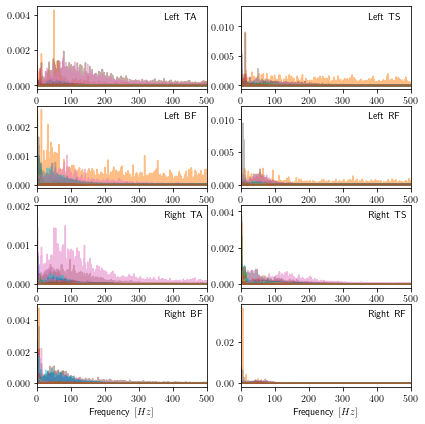

In [43]:
channels = ['Time','Label1','Label2']+['Left TA','Left TS','Left BF','Left RF', 'Right TA', 'Right TS', 'Right BF', 'Right RF']
sc = StandardScaler(with_mean=True)
i = 0

fn= 20
wn=2*fn/1000
b, a = signal.butter(2, wn, 'highpass')

fs = 1000.0  # Sample frequency (Hz)
f0 = 50  # Frequency to be removed from signal (Hz)
Q = 200.0  # Quality factor
# Design notch filter
b1, a1 = signal.iirnotch(f0, Q, fs)

fig = plt.figure(figsize=(6.7,7))
plt.rcParams.update({"text.usetex": True})
# plt.subplots_adjust(hspace=0.3)
AX = []
for j in range(8):
    AX += [fig.add_subplot(4,2,j+1)]
#     AX[j].set_title(channels[3+j],fontsize='medium')
#     AX[j].set_ylim([0,0.2])
#     AX[j].annotate(channels[3+j],(1010,700),xycoords='axes pixels')
    AX[j].annotate(channels[3+j],(0.75,0.85),xycoords='axes fraction')
    AX[j].set_xticks(np.arange(0,501,100))
    AX[j].set_xlim([0,500])
#     AX[j].set_ylim([0,0.2])

for file in files[:]:
    data = pd.read_csv('./data/'+file)
    data = data.dropna().reset_index(drop=True)
    ind = abs(zscore(data.iloc[:,3:],axis=0)) > 13
    ind = data.index[np.any(ind,axis=1)]
    data = data.drop(ind).reset_index(drop=True)
#     x_filter = signal.filtfilt(b,a,data.iloc[:,3:],axis=0)
#     x_filter = signal.filtfilt(b1,a1,x_filter,axis=0)
#     data.iloc[:,3:] = sc.fit_transform(data.iloc[:,3:])
#     data.iloc[:,3:] = normalize(data.iloc[:,3:],axis=1)
    data.iloc[:,3:] = rms_nm(data.iloc[:,3:])
#     data.iloc[:,3:] = x_filter
    
#     plt.title(file+'%d'%i)
    i = 0
    for c in data.columns[3:]:
#         freqs, power=signal.periodogram(signal.filtfilt(b, a, data.loc[:,c]), 1e3)
        freqs, power=signal.periodogram(data.loc[:,c], 1e3)
    #     plt.figure()
        
        fmax = np.argmax(power)
#         if (freqs[fmax] >49) & (freqs[fmax] <51):
#             print(file,':',c)
#         else:
#             freqs, power=signal.periodogram(signal.filtfilt(b1,a1,data.loc[:,c]), 1e3)
        AX[i].plot(freqs,power,alpha=0.5)
#         AX[i].plot(freqs,mean_smooth(power,50),alpha=0.5)
        i += 1
          
#         plt.xlim([0,200])
#     plt.legend(data.columns[3:])
AX[6].set_xlabel('Frequency $[Hz]$')
AX[7].set_xlabel('Frequency $[Hz]$')
# fig.savefig('./pic/thesis/PSD_of_all_data.jpg',dpi=600,format='jpg', bbox_inches='tight')

In [68]:
# fig.savefig('./pic/thesis/PSD_of_all_data.jpg',dpi=600,format='jpg', bbox_inches='tight')

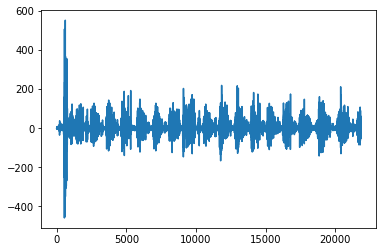

In [34]:
plt.plot(signal.filtfilt(b,a,data.iloc[:,3:],axis=0)[:,3])
# data = pd.read_csv('./data/'+file)
# plt.plot(data.iloc[:,4])
# data

In [176]:
# data.index[np.any(ind,axis=1)]
np.any(ind,axis=1)

(16583,)

In [88]:
a = np.array([1,2,3,4,5,4,3,2,1])
np.pad(a,3,'reflect')

array([4, 3, 2, 1, 2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4])

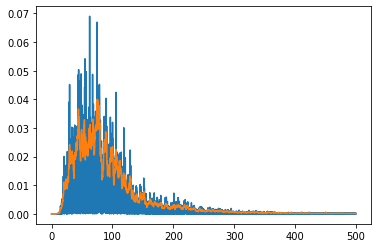

In [239]:
plt.plot(freqs,power)
# plt.xlim([0,200])
plt.plot(freqs,mean_smooth(power,20))
# plt.plot(freqs,utils.rectify_emg(power))

In [185]:
freqs[np.argmax(power)]

62.56875687568757

Text(0, 0.5, 'Power spectral density')

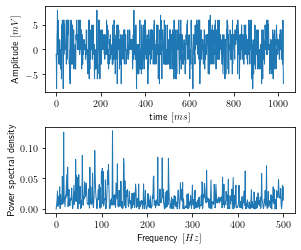

In [34]:
data = pd.read_csv('./data/'+files[8])
# data.isna().sum(axis=0)
# data = data.loc[:,channels].dropna()

data = data.fillna({'LEFT_TA':data.LEFT_TA.mean(),
                           'LEFT_TS':data.LEFT_TS.mean(),
                           'LEFT_BF':data.LEFT_BF.mean(),
                           'LEFT_RF':data.LEFT_RF.mean(),
                           'RIGHT_TA':data.RIGHT_TA.mean(),
                           'RIGHT_TS':data.RIGHT_TS.mean(),
                           'RIGHT_BF':data.RIGHT_BF.mean(),
                           'RIGHT_RF':data.RIGHT_RF.mean()})
# data.iloc[:,3:] = signal.filtfilt(b,a,data.iloc[:,3:],axis=0)
# data.iloc[:,3:] = sc.fit_transform(data.iloc[:,3:])
# data.iloc[:,3:] = signal.filtfilt(b1,a1,data.iloc[:,3:],axis=0)
ch = 10
# plt.figure(figsize=(12,8))
plt.figure(figsize=(0.7*6.4,3.8))
plt.rcParams.update({"text.usetex": True})
plt.subplots_adjust(hspace=0.4)
ax=plt.subplot(2,1,1)
plt.plot(np.array(data.iloc[:1024,ch]),linewidth=1)
ax.yaxis.get_major_formatter().set_powerlimits((0,1))
# plt.title('EMG Signal')
plt.xlabel('time $[ms]$')
plt.ylabel('Amplitude $[mV]$')
# plt.ylim((-8,8))
# plt.plot(dp.detrend(np.array(data.iloc[12000:14000,ch])[np.newaxis,:,np.newaxis],50)[0,:,0])
# plt.plot(signal.filtfilt(b,a,np.array(data.iloc[12000:14000,ch])))
# plt.ylim((-200,200))

# plt.figure(figsize=(0.8*6.4,0.8*3.8))
ax2=plt.subplot(2,1,2)
freqs, power=signal.periodogram(data.iloc[:1024,ch], 1e3,scaling='density')
# freqs, power=signal.periodogram(dp.detrend(np.array(data.iloc[12000:14000,ch])[np.newaxis,:,np.newaxis],50)[0,:,0], 1e3)
ax2.plot(freqs,power,linewidth=1)
# ax2.yaxis.get_major_formatter().set_powerlimits((0,1))
plt.xlabel('Frequency $[Hz]$')
plt.ylabel('Power spectral density')
# plt.xlim((20,300))

# plt.savefig('./pic/thesis/Power_spectral_density_of_abnormal_segments.pdf',dpi=600,format='pdf', bbox_inches='tight')

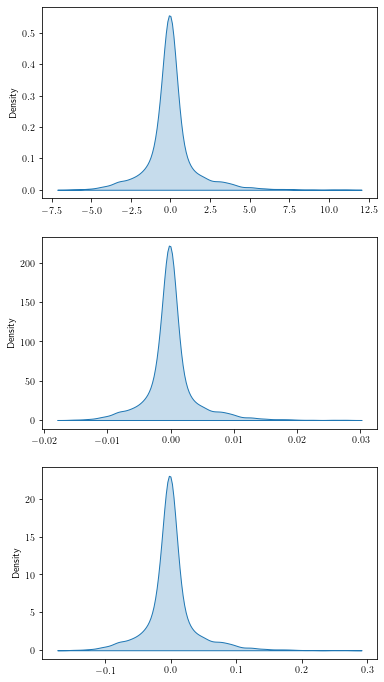

In [45]:
data = pd.read_csv('./data/'+files[5])
data = data.dropna().reset_index(drop=True)
# data.iloc[:,3:] = sc.fit_transform(data.iloc[:,3:])
# data.iloc[:,3:] = normalize(data.iloc[:,3:],axis=1)
freqs, power=signal.periodogram(data.iloc[5000:8000,7], 1e3,scaling='density')
# freqs, power=signal.periodogram(dp.detrend(np.array(data.iloc[12000:14000,ch])[np.newaxis,:,np.newaxis],50)[0,:,0], 1e3)
# plt.plot(freqs,power)
temp = sc.fit_transform(data.iloc[:,3:])
temp2 = normalize(data.iloc[:,3:],axis=0)
temp3 = rms_nm(data.iloc[:,3:])
plt.figure(figsize=(6,12))
plt.subplot(3,1,1)
# plt.plot(temp[8000:10000,3])
sns.kdeplot(temp[8000:10000,3],shade=True)
plt.subplot(3,1,2)
# plt.plot(temp2[8000:10000,3])
sns.kdeplot(temp2[8000:10000,3],shade=True)
plt.subplot(3,1,3)
# plt.plot(temp3[8000:10000,3])
sns.kdeplot(temp3[8000:10000,3],shade=True)
# plt.ylim((-8,8))

In [36]:
def detrend(signal, Lambda,return_trend=False):
    """detrend(signal, Lambda) -> filtered_signal
  
    This function applies a detrending filter.
   
    This code is based on the following article "An advanced detrending method with application
    to HRV analysis". Tarvainen et al., IEEE Trans on Biomedical Engineering, 2002.
  
    **Parameters**

    ``signal`` (1d numpy array):
    The signal where you want to remove the trend.

    ``Lambda`` (int):
    The smoothing parameter.

    **Returns**
  
    ``filtered_signal`` (1d numpy array):
    The detrended signal.
    """
    signal_length = signal.shape[1]
    #signal_res = signal.reshape
    # observation matrix
    H = np.identity(signal_length)
    # second-order difference matrix
    from scipy.sparse import spdiags
    ones = np.ones(signal_length)
    minus_twos = -2*np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index, (signal_length-2), signal_length).toarray()
    
    filtered_signal = (H - np.linalg.inv(H + (Lambda**2) * D.T@D))@signal
    if return_trend:
        trend = (np.linalg.inv(H + (Lambda**2) * D.T@D))@signal
        return filtered_signal,trend
    else:
        return filtered_signal
    
def rms(data):
    data = np.array(data)
    return np.sum(np.power(data,2),axis=0)/data.shape[0]

def rms_nm(data):
    rms_ = rms(data)
    return np.array(data)/rms_

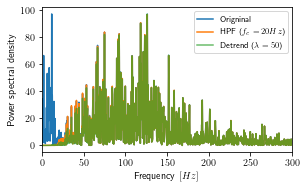

In [47]:
temp = data.iloc[5000:8000,7]
fn= 20
wn=2*fn/1000

plt.figure(figsize=(0.7*6.4,0.7*3.8))

b, a = signal.butter(4, wn, 'highpass')
freqs, power=signal.periodogram(temp, 1e3)
plt.plot(freqs,power)
freqs, power=signal.periodogram(signal.filtfilt(b, a, temp), 1e3)
plt.plot(freqs,power)
freqs, power=signal.periodogram(detrend(temp[np.newaxis,:,np.newaxis],50)[0,:,0], 1e3)
# plt.figure()
plt.plot(freqs,power,alpha=0.7)
# plt.ylim((0,2000))
plt.xlim((0,300))
plt.xlabel('Frequency $[Hz]$')
plt.ylabel('Power spectral density')
plt.legend(['Origninal','HPF ($f_c=20 Hz$)','Detrend ($\lambda=50$)'],fontsize=8)
# plt.savefig('./pic/thesis/detrend2.pdf',dpi=600,format='pdf', bbox_inches='tight')

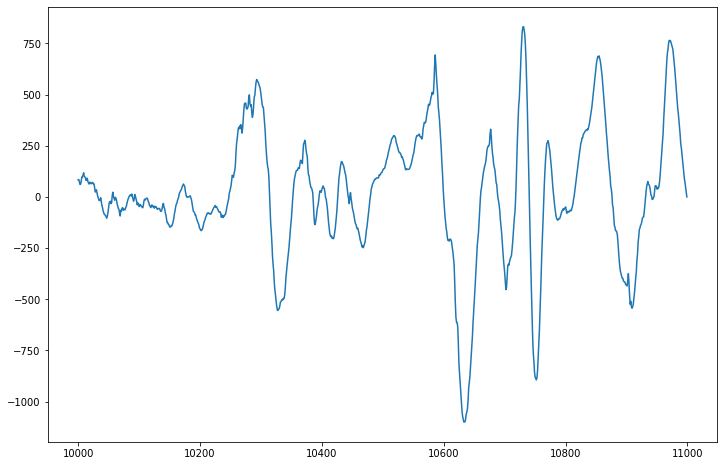

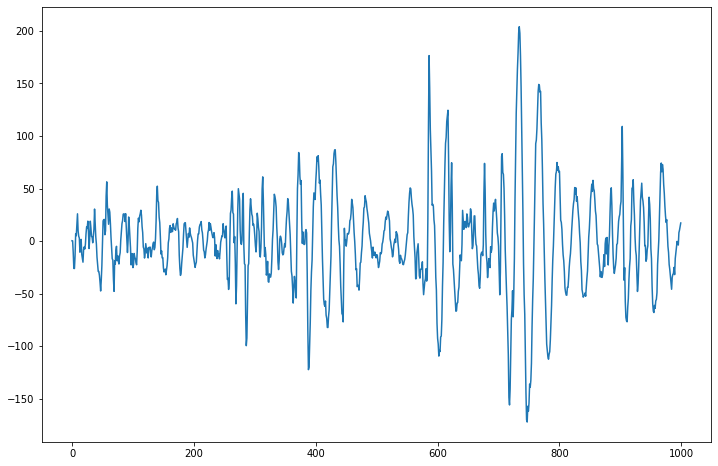

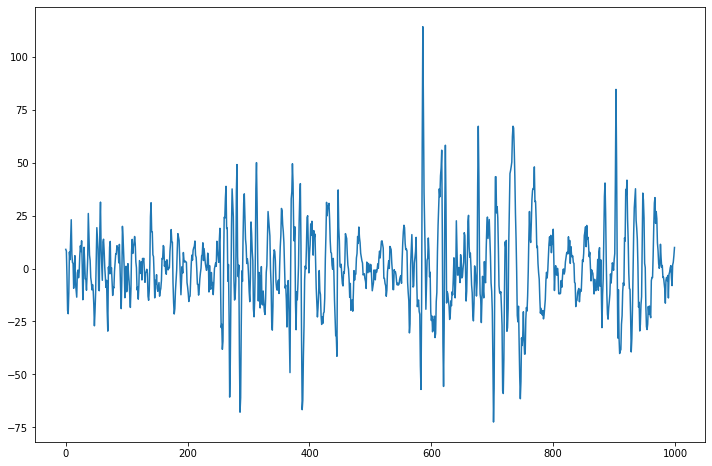

In [237]:
plt.figure(figsize=(12,8))
plt.plot(temp)

plt.figure(figsize=(12,8))
plt.plot(signal.filtfilt(b, a, temp))

plt.figure(figsize=(12,8))
plt.plot(detrend(temp[np.newaxis,:,np.newaxis],10)[0,:,0])

In [29]:
data = pd.read_csv('./data/'+files[5])
data = data.iloc[:,:].dropna().reset_index(drop=True)
ind = abs(zscore(data.iloc[:,3:],axis=0)) > 13
ind = data.index[np.any(ind,axis=1)]
data = data.drop(ind)#.reset_index(drop=True)

In [31]:
(np.array(data.Time[1:])-np.array(data.Time[:-1]))>0.001

array([False, False, False, ...,  True,  True,  True])

In [20]:
data.Time

0         0.000
1         0.001
2         0.002
3         0.003
4         0.004
          ...  
28863    28.961
28864    28.962
28865    28.963
28866    28.964
28867    28.965
Name: Time, Length: 28864, dtype: float64

In [28]:
result=np.load('./results/test/result0-others.npy',allow_pickle=True).item()

In [29]:
for item in result:
    print(item,': ',np.mean(result[item]['test']['acc']))

with_remove_no_zs :  0.9375
with_remove_zs_13 :  0.9465116279069766
with_remove_zs_20 :  0.9555555555555555
no_remove_no_zs :  0.9264637002341921
no_remove_zs_13 :  0.9422680412371134
no_remove_zs_20 :  0.9427230046948356


In [30]:
for item in result:
    print(item,':')
    for i in range(5):
        print(result[item]['test']['cm'][i])
        print('\n')

with_remove_no_zs :
[[280  11]
 [ 10  83]]


[[264  27]
 [  1  92]]


[[279  12]
 [  8  85]]


[[269  22]
 [  3  90]]


[[267  24]
 [  2  91]]


with_remove_zs_13 :
[[259   7]
 [ 24  54]]


[[257   9]
 [  1  77]]


[[260   6]
 [  2  76]]


[[261   5]
 [ 15  63]]


[[254  12]
 [ 11  67]]


with_remove_zs_20 :
[[282   8]
 [  3  94]]


[[273  17]
 [  0  97]]


[[274  16]
 [  2  95]]


[[279  11]
 [  5  92]]


[[272  18]
 [  6  91]]


no_remove_no_zs :
[[291  20]
 [  8 108]]


[[298  13]
 [  8 108]]


[[297  14]
 [ 16 100]]


[[293  18]
 [ 12 104]]


[[287  24]
 [ 24  92]]


no_remove_zs_13 :
[[278   9]
 [ 16  85]]


[[280   7]
 [ 10  91]]


[[282   5]
 [ 22  79]]


[[280   7]
 [ 15  86]]


[[279   8]
 [ 13  88]]


no_remove_zs_20 :
[[292  17]
 [  7 110]]


[[295  14]
 [ 11 106]]


[[300   9]
 [ 10 107]]


[[295  14]
 [ 25  92]]


[[301   8]
 [  7 110]]




In [58]:
freqs, power=signal.periodogram(data.iloc[:1024,3:], 1e3,axis=0)

In [91]:
plt.rcParams.update({"text.usetex": True})
ind = freqs<250
np.max(power[ind],axis=0)

97.11717770150567

In [50]:
temp=pd.DataFrame(np.array([[12,12,3,2,3,4],[1,2,3,12,2,23],[12,3,4,2,2,3],[1,2,3,1,33,3]]),columns=[1,2,3,4,5,6])

In [54]:
temp.drop(temp.index[(temp<2).any(axis=1)]).reset_index(drop=True)

,1,2,3,4,5,6
0,12,12,3,2,3,4
1,12,3,4,2,2,3


In [36]:
data = pd.read_csv('./data/'+files[5])
data = data.dropna().reset_index(drop=True)
width = 512
stride = 256
widths_scale = 32
x,y = dp.generate_window_slide_data(data,width,stride,scaler=True)

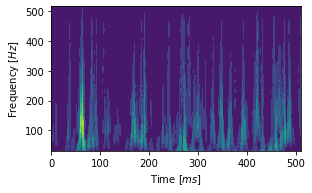

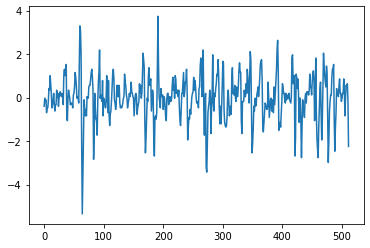

In [41]:
wave='mexh'
fc = pywt.central_frequency(wave)
totalscal=32
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal+1, 1, -1)
t = np.arange(0,width,1)
xx=x[115,:,2]
cwtmatr,f = pywt.cwt(xx,scales,wave,1e-3)
plt.figure(figsize=(0.7*6.4,0.7*3.8))
plt.contourf(t, f, abs(cwtmatr))
# plt.colorbar()
plt.ylabel('Frequency $[Hz]$')
plt.xlabel('Time $[ms]$')
# plt.savefig('./pic/thesis/cwt.pdf',dpi=600,format='pdf', bbox_inches='tight')
plt.figure()
plt.plot(t,xx)

In [28]:
cwtmatr

array([[ 0.26732546,  0.2994632 , -0.14140412, ...,  0.08924766,
         0.01083417, -0.06807701],
       [-0.0901559 ,  0.3620832 ,  0.155688  , ...,  0.06375971,
         0.08203034, -0.02916991],
       [ 0.04503754,  0.48276561,  0.01688977, ...,  0.09587707,
         0.08004649, -0.07209084],
       ...,
       [ 1.3860037 ,  1.7461349 ,  1.8531684 , ...,  0.48327047,
         0.44493398,  0.3554442 ],
       [ 1.8313273 ,  2.0118227 ,  2.0410469 , ...,  0.4128768 ,
         0.4255271 ,  0.39089745],
       [ 1.64805   ,  1.6286765 ,  1.4969114 , ..., -0.21111153,
        -0.07667001,  0.03359846]], dtype=float32)

In [2]:
f1_all={'XGBoost':{'binary':[0.82758,0.911217,0.966691],'multi':[0.290339,0.724214,0.582538]}}
f1_all['SVM']={'binary':[0.924647,0.900754,0.974556],'multi':[0.359325,0.73277,0.71121]}
f1_all['DNN']={'binary':[0.939155,0.902934,0.978474],'multi':[0.422539,0.717960,0.66169]}
f1_all['CWT-CNN']={'binary':[0.872298,0.898577,0.960854],'multi':[0.219553,0.693864,0.595899]}
f1_all['CNN-PA']={'binary':[0.906403,0.898089,0.976491],'multi':[0.351136,0.704221,0.608743]}
f1_all['LSTM-CNN']={'binary':[0.935139,0.911056,0.960817],'multi':[0.226053,0.646001,0.602951]}

In [3]:
f1_pd=pd.DataFrame()
for key in f1_all:
    for c in f1_all[key]:
#         if c=='binary':
#             binary.append(np.mean(f1[key][c]))
#         else:
#             multi.append(np.mean(f1[key][c]))
        temp=pd.DataFrame([[np.mean(f1_all[key][c]),key,c]],columns=['F1-score','Model','Task'])
        f1_pd=pd.concat([f1_pd,temp],ignore_index=True)

In [4]:
f1_pd['Side']='Both'

In [5]:
sns.set_theme(style="whitegrid")

In [6]:
sns.set(font_scale=0.8)

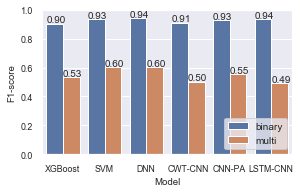

In [8]:
plt.figure(figsize=(0.7*6.4,0.7*3.8))
g=sns.barplot(x='Model',y='F1-score',hue='Task',data=f1_pd)
plt.ylim((0,1))
plt.legend(loc='lower right',fontsize=10)
for ind,row in f1_pd.iterrows():
    if row.name%2==0:
        g.text((row.name//2)-0.4,row['F1-score']+0.01,'%0.2f'%row['F1-score'],fontsize=10)
    else:
        g.text((row.name//2),row['F1-score']+0.01,('%0.2f'%row['F1-score']),fontsize=10)
# plt.savefig('./pic/thesis/overall result1.pdf',dpi=600,format='pdf', bbox_inches='tight')

In [9]:
cms={}
cms['XGBoost']={'T1':[[0,13,0],[1,7,1],[5,32,34]],'T2':[[22,13,3],[11,42,1],[10,3,62]],'T3':[[33,41,16],[8,59,10],[13,15,56]]}
cms['SVM']={'T1':[[3,10,0],[0,9,0],[4,42,25]],'T2':[[33,5,0],[22,32,0],[12,3,60]],'T3':[[53,12,25],[14,59,4],[14,4,66]]}
cms['DNN']={'T1':[[3,7,3],[0,4,5],[8,13,50]],'T2':[[27,11,0],[20,34,0],[8,4,63]],'T3':[[39,16,35],[13,57,7],[6,6,72]]}
cms['CWT-CNN']={'T1':[[1,12,0],[1,7,1],[16,38,17]],'T2':[[25,10,3],[21,33,0],[13,0,62]],'T3':[[27,31,32],[12,61,4],[18,1,65]]}
cms['CNN-PA']={'T1':[[3,10,0],[0,8,1],[11,32,28]],'T2':[[9,18,11],[1,53,0],[2,1,72]],'T3':[[24,27,39],[10,59,8],[4,3,77]]}
cms['LSTM-CNN']={'T1':[[7,6,0],[6,2,1],[40,16,15]],'T2':[[20,10,8],[13,40,1],[21,3,51]],'T3':[[20,31,39],[9,61,7],[5,3,76]]}

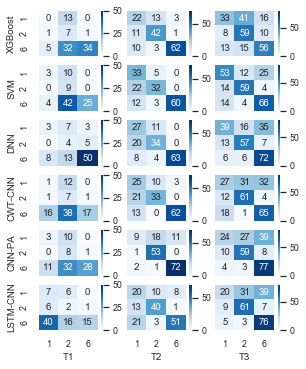

In [11]:
i=1
plt.figure(figsize=(0.7*6.4,0.7*8.4))
yl={1:'XGBoost',4:'SVM',7:'DNN',10:'CWT-CNN',13:'CNN-PA',16:'LSTM-CNN'}
xl={16:'T1',17:'T2',18:'T3'}
for m in cms:
    for t in cms[m]:
        plt.subplot(6,3,i)
        if i in [1,4,7,10,13,16]:
            sns.heatmap(data=cms[m][t],annot=True,cmap='Blues',vmin=0,vmax=50)
            plt.ylabel(yl[i])
        elif i in [2,5,8,11,14,17]:
            sns.heatmap(data=cms[m][t],annot=True,cmap='Blues',vmin=0,vmax=70)
        else:
            sns.heatmap(data=cms[m][t],annot=True,cmap='Blues',vmin=0,vmax=80)
        if i not in [1,4,7,10,13,16]:
            plt.yticks([])
        else:
            plt.yticks([0.5,1.5,2.5],['1','2','6'])
        if i in [16,17,18]:
            plt.xticks([0.5,1.5,2.5],['1','2','6'])
            plt.xlabel(xl[i])
        i+=1
# plt.savefig('./pic/thesis/cms.pdf',dpi=600,format='pdf', bbox_inches='tight')

In [23]:
f1={'XGBoost':{'Left':{'binary':[0.868276,0.902437,0.954387],'multi':[0.178175,0.667022,0.618871]},'Right':{'binary':[0.787643,0.904494,0.948906],'multi':[0.320003,0.687068,0.569275]}}}
f1['SVM']={'Left':{'binary':[0.882121,0.884678,0.975315],'multi':[0.100974,0.614849,0.577496]},'Right':{'binary':[0.628704,0.889381,0.953827],'multi':[0.284649,0.683602,0.660926]}}
f1['DNN']={'Left':{'binary':[0.904407,0.892786,0.960069],'multi':[0.120176,0.61286,0.573252]},'Right':{'binary':[0.423448,0.887418,0.965767],'multi':[0.306645,0.661227,0.566022]}}
f1['CWT-CNN']={'Left':{'binary':[0.899151,0.890279,0.962019],'multi':[0.1375,0.589351,0.568335]},'Right':{'binary':[0.624598,0.905212,0.957459],'multi':[0.406058,0.737835,0.610994]}}
f1['CNN-PA']={'Left':{'binary':[0.933974,0.889789,0.963845],'multi':[0.265359,0.696344,0.555220]},'Right':{'binary':[0.641809,0.873786,0.946986],'multi':[0.333648,0.735097,0.605698]}}
f1['LSTM-CNN']={'Left':{'binary':[0.898662,0.909382,0.960055],'multi':[0.204836,0.571733,0.485037]},'Right':{'binary':[0.867673,0.918251,0.923450],'multi':[0.221367,0.660312,0.548631]}}

In [24]:
f1

{'XGBoost': {'Left': {'binary': [0.868276, 0.902437, 0.954387],
   'multi': [0.178175, 0.667022, 0.618871]},
  'Right': {'binary': [0.787643, 0.904494, 0.948906],
   'multi': [0.320003, 0.687068, 0.569275]}},
 'SVM': {'Left': {'binary': [0.882121, 0.884678, 0.975315],
   'multi': [0.100974, 0.614849, 0.577496]},
  'Right': {'binary': [0.628704, 0.889381, 0.953827],
   'multi': [0.284649, 0.683602, 0.660926]}},
 'DNN': {'Left': {'binary': [0.904407, 0.892786, 0.960069],
   'multi': [0.120176, 0.61286, 0.573252]},
  'Right': {'binary': [0.423448, 0.887418, 0.965767],
   'multi': [0.306645, 0.661227, 0.566022]}},
 'CWT-CNN': {'Left': {'binary': [0.899151, 0.890279, 0.962019],
   'multi': [0.1375, 0.589351, 0.568335]},
  'Right': {'binary': [0.624598, 0.905212, 0.957459],
   'multi': [0.406058, 0.737835, 0.610994]}},
 'CNN-PA': {'Left': {'binary': [0.933974, 0.889789, 0.963845],
   'multi': [0.265359, 0.696344, 0.55522]},
  'Right': {'binary': [0.641809, 0.873786, 0.946986],
   'multi': [0

In [25]:
f1_lr_pd=pd.DataFrame()
for key in f1:
    for s in f1[key]:
        for c in f1[key][s]:
            temp=pd.DataFrame([[np.mean(f1[key][s][c]),key,c,s]],columns=['F1-score','Model','Task','Side'])
            f1_lr_pd=pd.concat([f1_lr_pd,temp],ignore_index=True)
f1_lr_pd=pd.concat([f1_lr_pd,f1_pd],ignore_index=True)

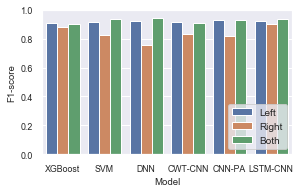

In [31]:
indf=f1_lr_pd.Task=='binary'
plt.figure(figsize=(0.7*6.4,0.7*3.8))
g=sns.barplot(x='Model',y='F1-score',hue='Side',data=f1_lr_pd.loc[indf,:])
plt.ylim((0,1))
plt.legend(loc='lower right',fontsize=10)
i=0
# for ind,row in f1_lr_pd.loc[indf,:].iterrows():
#     if i%2==0:
#         g.text((i//2)-0.45,row['F1-score']+0.01,'%0.2f'%row['F1-score'],fontsize=10)
#     else:
#         g.text((i//2),row['F1-score']+0.01,('%0.2f'%row['F1-score']),fontsize=10)
#     i+=1
# plt.savefig('./pic/thesis/result side b.pdf',dpi=600,format='pdf', bbox_inches='tight')

In [27]:
f1_lr_pd2=pd.DataFrame()
for key in f1:
    for s in f1[key]:
        for c in f1[key][s]:
            temp=pd.DataFrame([f1[key][s][c]+[key,c,s]],columns=['T1','T2','T3','Model','Task','Side'])
            f1_lr_pd2=pd.concat([f1_lr_pd2,temp],ignore_index=True)

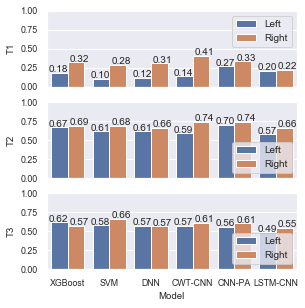

In [34]:
indf=f1_lr_pd2.Task=='multi'
plt.figure(figsize=(0.7*6.4,0.7*6.8))
for i,t in enumerate(['T1','T2','T3']):
    plt.subplot(3,1,i+1)
    g=sns.barplot(x='Model',y=t,hue='Side',data=f1_lr_pd2.loc[indf,:])
    plt.ylim((0,1))
    if i==0:
        plt.legend(loc='upper right',fontsize=10)
    else:
        plt.legend(loc='lower right',fontsize=10)
    if i!=2:
        plt.xticks([])
        plt.xlabel('')
    j=0
    for ind,row in f1_lr_pd2.loc[indf,:].iterrows():
        if j%2==0:
            g.text((j//2)-0.45,row[t]+0.01,'%0.2f'%row[t],fontsize=10)
        else:
            g.text((j//2)+0.05,row[t]+0.01,('%0.2f'%row[t]),fontsize=10)
        j+=1
# plt.savefig('./pic/thesis/result lr m.pdf',dpi=600,format='pdf', bbox_inches='tight')

In [41]:
f1_lr_pd

,F1-score,Model,Task,Side
0,0.908367,XGBoost,binary,Left
1,0.488023,XGBoost,multi,Left
2,0.880348,XGBoost,binary,Right
3,0.525449,XGBoost,multi,Right
4,0.914038,SVM,binary,Left
5,0.431106,SVM,multi,Left
6,0.823971,SVM,binary,Right
7,0.543059,SVM,multi,Right
8,0.916075,DNN,binary,Left
9,0.441691,DNN,multi,Left


In [35]:
data=pd.read_excel('E:/Document/jupyter/Master Thesis/results/eval/overall results.xlsx','muscle',header=[0,1],index_col=0).T

In [36]:
f1_ms={}
for m in data.columns:
    f1_ms[m]={}
    for ms in data.index:
        f1_ms[m][ms[0]]=list(data.loc[ms[0],m])
        
f1_ms_pd=pd.DataFrame()
Ts=['T1','T2','T3']
for mo in f1_ms:
    for s in f1_ms[mo]:
        for i,v in enumerate(f1_ms[mo][s]):
            temp=pd.DataFrame([[v,mo,s,Ts[i]]],columns=['F1-score','Model','Muscle','Set'])
            f1_ms_pd=pd.concat([f1_ms_pd,temp],ignore_index=True)

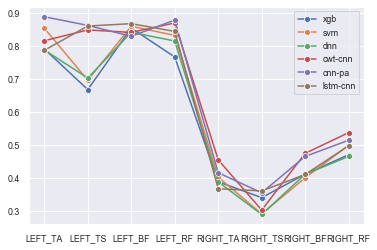

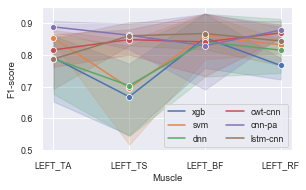

In [40]:
ind=(f1_ms_pd.Muscle.values == 'LEFT_TS') | (f1_ms_pd.Muscle.values == 'LEFT_TA') | (f1_ms_pd.Muscle.values == 'LEFT_BF') | (f1_ms_pd.Muscle.values == 'LEFT_RF')
# ind=(f1_ms_pd.Muscle.values == 'RIGHT_TS') | (f1_ms_pd.Muscle.values == 'RIGHT_TA') | (f1_ms_pd.Muscle.values == 'RIGHT_BF') | (f1_ms_pd.Muscle.values == 'RIGHT_RF')
plt.figure()
for k,v in f1_ms.items():
    sns.lineplot(x=list(f1_ms[k].keys()),y=np.mean(list(f1_ms[k].values()),axis=1),marker='o',label=k)
plt.figure(figsize=(0.7*6.4,0.7*3.8))
sns.lineplot(x='Muscle',y='F1-score',hue='Model',data=f1_ms_pd.loc[ind,:],marker='o')
# plt.ylim([0.3,1])
plt.legend(loc='lower right',ncol=2)
# plt.savefig('./pic/thesis/result mus b.pdf',dpi=600,format='pdf', bbox_inches='tight')

In [23]:
f1_ms_pd

,F1-score,Model,Muscle,Set
0,0.652943,xgb,LEFT_TA,T1
1,0.860032,xgb,LEFT_TA,T2
2,0.861072,xgb,LEFT_TA,T3
3,0.546495,xgb,LEFT_TS,T1
4,0.772914,xgb,LEFT_TS,T2
...,...,...,...,...
139,0.426319,lstm-cnn,RIGHT_BF,T2
140,0.352413,lstm-cnn,RIGHT_BF,T3
141,0.449890,lstm-cnn,RIGHT_RF,T1
142,0.601058,lstm-cnn,RIGHT_RF,T2


In [20]:
(f1_ms_pd.Muscle.values == 'LEFT_TS') and (f1_ms_pd.Muscle.values == 'LEFT_TA') and (f1_ms_pd.Muscle.values == 'LEFT_BF') and (f1_ms_pd.Muscle.values == 'LEFT_RF')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [26]:
(f1_ms_pd.Muscle.values == 'LEFT_TS') | (f1_ms_pd.Muscle.values == 'LEFT_TA')

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
       False, False,

In [55]:
a=[0.891307,
 0.827733,
 0.927607,
 0.916849,
 0.873551,
 ]

In [56]:
np.mean(a)

0.8874093999999999

In [32]:
a=[0.4562799714314865,
 0.44827568158860265,
 0.45161425576519915,
 0.43302891933028914,
 0.44265776859722994,
 0.4520502645502645
 ]

In [33]:
np.mean(a)

0.44731781021051203

In [4]:
a=[3,2,1]
b=['s','a','b']
for i in enumerate(zip(a,b)):
    print(i)

(0, (3, 's'))
(1, (2, 'a'))
(2, (1, 'b'))


In [5]:
1!=0

True